Basis for notebook is found here: https://github.com/AlgoveraAI/DeFi-borrowing-cost-prediction

# Author - Vintage Gold

# Goal of this notebook

- [X] EDA on Compound on Aave dataset including correlation
- [X] Try simple LR for some trial modeling

# Initialize Random State

In [2]:
random_state=3

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
! pip install matplotlib


In [4]:

df = pd.read_csv('Compound_-_Data_1.csv')
df["Date"] = pd.to_datetime(df["Timestamp"], unit='s', origin='unix')

df["Token"].unique()

array(['DAI', 'USDC', 'USDT', 'ETH'], dtype=object)

In [5]:
df

Timestamp Token  ...  Supply Volume                Date
0      1609471800   DAI  ...   6.196481e+10 2021-01-01 03:30:00
1      1609471800  USDC  ...   4.063042e+10 2021-01-01 03:30:00
2      1609471800  USDT  ...   3.696225e+09 2021-01-01 03:30:00
3      1609471800   ETH  ...   5.663257e+07 2021-01-01 03:30:00
4      1609473600   DAI  ...   6.197050e+10 2021-01-01 04:00:00
...           ...   ...  ...            ...                 ...
66789  1639539000   ETH  ...   7.481990e+07 2021-12-15 03:30:00
66790  1639540800   ETH  ...   7.482188e+07 2021-12-15 04:00:00
66791  1639542600   ETH  ...   7.482482e+07 2021-12-15 04:30:00
66792  1639544400   ETH  ...   7.461519e+07 2021-12-15 05:00:00
66793  1639546200   ETH  ...   7.456406e+07 2021-12-15 05:30:00

[66794 rows x 7 columns]

In [6]:
import plotly.express as px

import plotly.graph_objects as go

px.line(df,x="Date",y="Borrowing Rate",template="plotly_dark",title="Borrowing Rate Overtime",facet_col="Token")

In [7]:
# Appears to be just using deposit rate would predict borrowing rate.
# I would think the relationship would be inverse instead of same direction
# Since, the more supply of money available, the more incentivize to borrow 
# i.e with a low borrowing rate, but that doesn't appear to be how compound works
df.corr()

Timestamp  Borrowing Rate  ...  Borrow Volume  Supply Volume
Timestamp        1.000000       -0.385611  ...       0.269043       0.281849
Borrowing Rate  -0.385611        1.000000  ...       0.071499       0.012758
Deposit Rate    -0.342517        0.985969  ...       0.161773       0.107127
Borrow Volume    0.269043        0.071499  ...       1.000000       0.989878
Supply Volume    0.281849        0.012758  ...       0.989878       1.000000

[5 rows x 5 columns]

In [8]:
from sklearn.preprocessing import LabelEncoder
f_dataset_size = 0.10

#Set aside dataset for final modeling to test hypothesis
df_final_test = df.tail(round(len(df) * 0.10))

df = df.drop(index=df_final_test.index)

#Assign label encoding to Tokens
le = LabelEncoder()
df["Token_label"] = le.fit_transform(df["Token"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60115 entries, 0 to 60114
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Timestamp       60115 non-null  int64         
 1   Token           60115 non-null  object        
 2   Borrowing Rate  60115 non-null  float64       
 3   Deposit Rate    60115 non-null  float64       
 4   Borrow Volume   60115 non-null  float64       
 5   Supply Volume   60115 non-null  float64       
 6   Date            60115 non-null  datetime64[ns]
 7   Token_label     60115 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 4.1+ MB


In [9]:
df

Timestamp Token  ...                Date  Token_label
0      1609471800   DAI  ... 2021-01-01 03:30:00            0
1      1609471800  USDC  ... 2021-01-01 03:30:00            2
2      1609471800  USDT  ... 2021-01-01 03:30:00            3
3      1609471800   ETH  ... 2021-01-01 03:30:00            1
4      1609473600   DAI  ... 2021-01-01 04:00:00            0
...           ...   ...  ...                 ...          ...
60110  1636520400  USDT  ... 2021-11-10 05:00:00            3
60111  1636520400  USDT  ... 2021-11-10 05:00:00            3
60112  1636520400   ETH  ... 2021-11-10 05:00:00            1
60113  1636522200   DAI  ... 2021-11-10 05:30:00            0
60114  1636522200  USDC  ... 2021-11-10 05:30:00            2

[60115 rows x 8 columns]

# Deposit Rate is baked into the Borrowing Rate calc, so just a simple linear regression could tell you the answer.  You may not even need ML, might just be tracking the deposit rate and when it's high don't borrow and when low borrow.
# InstaDapp is also a cool defi project that could be a good integration for a borrow rate predictor - https://defi.instadapp.io/

Here is the code from Compound's Github that might shed light, but I don't know solidity - https://github.com/compound-finance/compound-protocol/blob/master/contracts/BaseJumpRateModelV2.sol

    /**
     * @notice Calculates the current borrow rate per block, with the error code expected by the market
     * @param cash The amount of cash in the market
     * @param borrows The amount of borrows in the market
     * @param reserves The amount of reserves in the market
     * @return The borrow rate percentage per block as a mantissa (scaled by 1e18)
     */
    function getBorrowRateInternal(uint cash, uint borrows, uint reserves) internal view returns (uint) {
        uint util = utilizationRate(cash, borrows, reserves);

        if (util <= kink) {
            return util.mul(multiplierPerBlock).div(1e18).add(baseRatePerBlock);
        } else {
            uint normalRate = kink.mul(multiplierPerBlock).div(1e18).add(baseRatePerBlock);
            uint excessUtil = util.sub(kink);
            return excessUtil.mul(jumpMultiplierPerBlock).div(1e18).add(normalRate);
        }
    }

     * @notice Calculates the current supply rate per block
     * @param cash The amount of cash in the market
     * @param borrows The amount of borrows in the market
     * @param reserves The amount of reserves in the market
     * @param reserveFactorMantissa The current reserve factor for the market
     * @return The supply rate percentage per block as a mantissa (scaled by 1e18)

    function getSupplyRate(uint cash, uint borrows, uint reserves, uint reserveFactorMantissa) public view returns (uint) {
        uint oneMinusReserveFactor = uint(1e18).sub(reserveFactorMantissa);
        uint borrowRate = getBorrowRateInternal(cash, borrows, reserves);
        uint rateToPool = borrowRate.mul(oneMinusReserveFactor).div(1e18);
        return utilizationRate(cash, borrows, reserves).mul(rateToPool).div(1e18);
    }

In [11]:
import plotly.express as px

import plotly.graph_objects as go

In [12]:
px.line(df,x=df.index,y="Borrowing Rate",color="Token",
        template="plotly_dark",title="Borrowing Rate Overtime")

In [13]:
px.scatter(df,x="Deposit Rate",y="Borrowing Rate",color="Token",
           title="Deposit to Borrowing Rate - Highly Positively Corr Across All Tokens - Besides Eth?",
           template="plotly_dark")

# Rough Modeling and programming flow - Sorry for the double code

In [14]:
#Build a simple Linear regression and split train test

from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score

X = df[[col for col in df.columns if col != "Borrowing Rate" and col != "Token" and col != "TimeStamp" and col != "Token_label" and col != "Date"]]

y = df["Borrowing Rate"]

X_norm = MinMaxScaler().fit_transform(X)

token_label_array = df["Token_label"].to_numpy()[:,np.newaxis]

X_norm_withlabels = np.hstack((X_norm,token_label_array))

#Make sure stratify so all Token labels are equally in test and train. 
#This actually doesn't really matter as the dataset is even, 
#but just for good fundamentals
X_train, X_test, y_train, y_test = tts(X_norm_withlabels,y.to_numpy(),train_size=0.80,stratify=df["Token_label"])

In [15]:
train, count_train = np.unique(X_train[:,4],return_counts=True)

test, count_test = np.unique(X_test[:,4],return_counts=True)

In [16]:
#Token is even split between test and train sets
train,count_train,test,count_test

(array([0., 1., 2., 3.]),
 array([12023, 12023, 12023, 12023]),
 array([0., 1., 2., 3.]),
 array([3006, 3005, 3006, 3006]))

## Results

## Would be interesting to see what the performance is like without highly correlated feature of Deposit Rate

In [17]:
model = LR()

model.fit(X_train,y_train)

y_preds = model.predict(X_test)

print(type(model).__name__,":",r2_score(y_test,y_preds))

LinearRegression : 0.9908695800518037


# Without Deposit Rate - I don't trust the decision tree results there must be some relationship that wasn't identified, 99 on train and test with little tuning seems too easy


In [18]:
#Build a simple Linear regression and split train test

from sklearn.linear_model import LinearRegression,RidgeCV,BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score

X = df[[col for col in df.columns if col != "Borrowing Rate" 
        and col != "Token" 
        and col != "TimeStamp" and col != "Token_label" 
        and col != "Deposit Rate" and col != "Date"]]

y = df["Borrowing Rate"]

X_norm = MinMaxScaler().fit_transform(X)

token_label_array = df["Token_label"].to_numpy()[:,np.newaxis]

#Put labels back in since they don't need to be normalized
X_norm_withlabels = np.hstack((X_norm,token_label_array))

#Make sure stratify so all Token labels are equally in test and train. 
#This actually doesn't really matter as the dataset is even, 
#but just for good fundamentals
X_train, X_test, y_train, y_test = tts(X_norm_withlabels,y.to_numpy(),
                                       train_size=0.80,
                                       stratify=df["Token_label"])

models = [LinearRegression(),RidgeCV(cv=3),BayesianRidge(),
          DecisionTreeRegressor()]

for model in models:

    model.fit(X_train,y_train)


    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)


    print(type(model).__name__,":",r2_score(y_train,y_preds_train),r2_score(y_test,y_preds_test))

LinearRegression : 0.4042459447668594 0.39494652397123997
RidgeCV : 0.40424542004050135 0.39494735913661283
BayesianRidge : 0.4042459295406293 0.3949467404444045
DecisionTreeRegressor : 0.9999999999999981 0.9945204700284666


# Aave and Compound Comparison

In [20]:
aave = pd.read_csv('aave2.csv')

In [21]:
aave

symbol  ... avg_variable_borrow_rate
0        USDC  ...                 3.651738
1         DAI  ...                 3.844345
2        USDC  ...                 3.635794
3        USDT  ...                 3.458650
4        USDC  ...                 3.623783
...       ...  ...                      ...
100564   USDC  ...                 1.591810
100565    DAI  ...                 0.075189
100566    DAI  ...                 0.141511
100567    DAI  ...                 2.500015
100568    DAI  ...                 1.250000

[100569 rows x 5 columns]

In [22]:
aave["datetime"] = pd.to_datetime(aave["date"])

In [23]:
df_aave = aave.set_index("datetime").resample("d").median()

In [24]:
df["Borrowing Rate Scaled"] = df["Borrowing Rate"] * 100
df_compound = df.set_index("Date").resample("d").median()

In [25]:
df_compound

Timestamp  Borrowing Rate  ...  Token_label  Borrowing Rate Scaled
Date                                      ...                                    
2021-01-01  1.609508e+09        0.060521  ...          1.5               6.052116
2021-01-02  1.609588e+09        0.050376  ...          1.5               5.037648
2021-01-03  1.609674e+09        0.072744  ...          1.5               7.274354
2021-01-04  1.609760e+09        0.079682  ...          1.5               7.968241
2021-01-05  1.609846e+09        0.078583  ...          1.5               7.858338
...                  ...             ...  ...          ...                    ...
2021-11-06  1.636199e+09        0.049740  ...          1.5               4.974012
2021-11-07  1.636286e+09        0.046551  ...          1.0               4.655075
2021-11-08  1.636373e+09        0.044415  ...          2.0               4.441514
2021-11-09  1.636459e+09        0.046598  ...          1.0               4.659837
2021-11-10  1.636512e+09        0.046527  ...          2.0               4.652686

[314 rows x 7 columns]

In [26]:
aave_borrowing = df_aave["avg_variable_borrow_rate"]
compound_borrowing = df_compound["Borrowing Rate Scaled"]

In [27]:
aave_borrowing.shape,compound_borrowing.shape

((380,), (314,))

In [28]:
data_range = min(aave_borrowing.shape[0],compound_borrowing.shape[0])

np.corrcoef(aave_borrowing[:data_range],compound_borrowing[:data_range])

array([[1.        , 0.20227117],
       [0.20227117, 1.        ]])

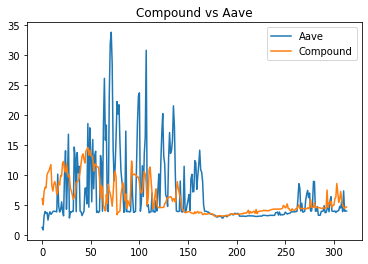

In [39]:
_ = plt.title("Compound vs Aave")
_ = plt.plot(list(range(0,data_range)),aave_borrowing[:data_range],label="Aave")
_ = plt.plot(list(range(0,data_range)),compound_borrowing[:data_range],label="Compound")
_= plt.legend()

In [40]:
print(aave['symbol'].unique())

['USDC' 'DAI' 'USDT' 'WETH']


#Windowing

In [19]:
def all_tokens_define_window(df,r_window=4,r_minperiods=3,e_minperiods=3,):

    df['expand_mean']=df['Borrowing Rate'].expanding(min_periods=e_minperiods).mean()
    df['roll_mean']=df['Borrowing Rate'].rolling(r_window,min_periods=r_minperiods).mean()

    return df

def specific_token_define_window(df,r_window=5,r_minperiods=3,e_minperiods=3):

    df_window = pd.DataFrame()

    for token in df["Token"].unique():

        print("Processing",token)
    
        df_token = df.query(f'Token == "{token}"')[["Date","Token","Borrowing Rate"]]

        print("Token in dataset",df_token["Token"].unique())

        df_token['expand_mean']=df_token['Borrowing Rate'].expanding(min_periods=e_minperiods).mean()
        df_token['roll_mean']=df_token['Borrowing Rate'].rolling(r_window,min_periods=r_minperiods).mean()

        df_window = pd.concat([df_window,df_token])

    return df

df_all = all_tokens_define_window(df.copy())

df_token = specific_token_define_window(df.copy())

df_all.head()

df_token.head()

Processing DAI
Token in dataset ['DAI']
Processing USDC
Token in dataset ['USDC']
Processing USDT
Token in dataset ['USDT']
Processing ETH
Token in dataset ['ETH']


Timestamp Token  ...                Date  Token_label
0  1609471800   DAI  ... 2021-01-01 03:30:00            0
1  1609471800  USDC  ... 2021-01-01 03:30:00            2
2  1609471800  USDT  ... 2021-01-01 03:30:00            3
3  1609471800   ETH  ... 2021-01-01 03:30:00            1
4  1609473600   DAI  ... 2021-01-01 04:00:00            0

[5 rows x 8 columns]